In [8]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
cd /content/drive/Othercomputers/My Laptop/New folder/Transformer

/content/drive/Othercomputers/My Laptop/New folder/Transformer


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn
from model.layer.encoder import Encoder


ModuleNotFoundError: ignored

### Load dataset

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.9 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

In [ ]:
data = load_dataset("emotion")

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
data['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

### From dataset to DataFrames

In [ ]:
import pandas as pd

data.set_format(type = "pandas")
train = data['train'][:]
train.head(5)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
def label_int2str(row,split):
    return data[split].features['label'].int2str(row)
train['label_name'] = train['label'].apply(label_int2str,split = 'train')
train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


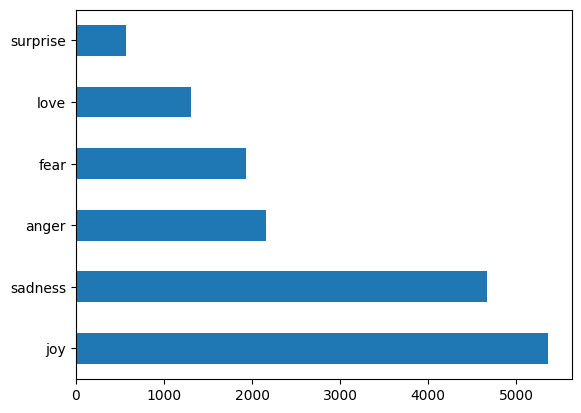

In [ ]:
train['label_name'].value_counts().plot.barh()
plt.title("")
plt.show()

* Tập dữ liệu bị mất cân bằng:
    * Resampling lại các lớp ít
    * Đánh trọng số cho hàm loss với từng lớp

Xem xét độ dài của từng câu

In [ ]:
train['Length'] = train['text'].apply(lambda x: len(x.split()))

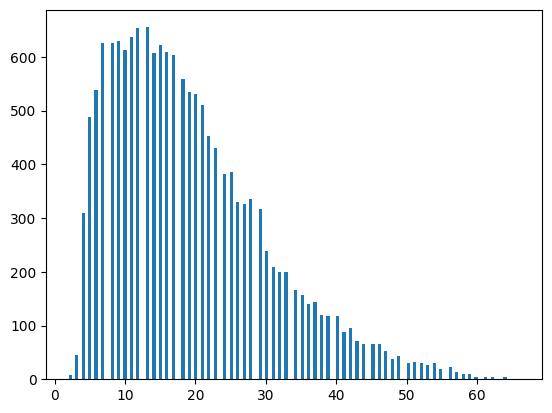

In [ ]:
plt.hist(train['Length'],bins=140)
plt.show()

* Nhỏ nhất là 4 và lớn nhất là 66
* Phần lớn độ dài nằm ở khoảng từ 5-> 25

Với từng lớp thì sao ?

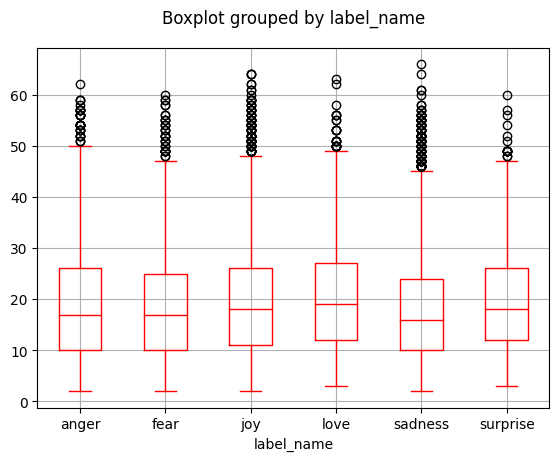

In [ ]:
train.boxplot("Length",by='label_name',color = 'red')
plt.title("")
plt.show()


### Text -> Token

Có nhiều level token:
* Character Tokenization
* Word Tokenization
* Subword Tokenization


Có thể sử dụng Pretrain Token

In [ ]:
!pip install transformers

Tokenizing the Whole Dataset

In [ ]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [ ]:
print("Size of pretrain model: ",tokenizer.vocab_size)
print("Special token: ",tokenizer.special_tokens_map)

Size of pretrain model:  30522
Special token:  {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}


* Encoder example

In [ ]:
sentence = "Nice to meet you"
print("Example: ",sentence)
print("Tokenizer: ",tokenizer.encode(sentence))

Example:  Nice to meet you
Tokenizer:  [101, 3835, 2000, 3113, 2017, 102]


* Decoder example

In [ ]:
tokens = [102,2825,3835,3113,2017]
print("Emxample:",tokens)
print("Sentece: ",tokenizer.decode(tokens))

Emxample: [102, 2825, 3835, 3113, 2017]
Sentece:  [SEP] possible nice meet you


In [ ]:
def tokenize(batch):
  return tokenizer(batch['text'],padding = True, truncation = True)


In [ ]:
data.reset_format()
data_encoded = data.map(tokenize,batched = True, batch_size = None)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
data_encoded['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [ ]:
len(data_encoded['train'][1]['input_ids']),len(data_encoded['train'][0]['attention_mask'])

(87, 87)

In [ ]:
Max_length = 87


### 2. Model

Đến đây chúng ta có ba options để train model
* Build lại model
* Feature extraction using pretrain
* Fine-tuning


In [6]:
class TransformerEncoder(nn.Module):
  def __init__(self,n_layers,src_vocab_size,max_len,d_model,n_heads,ff_dim,hidden_dim,num_classes,dropout = 0.5):
    super().__init__()
    self.encoder = Encoder(n_layers,src_vocab_size,max_len,d_model,n_heads,ff_dim,dropout)
    self.dropout = nn.Dropout(dropout)
    self.linear  = nn.Linear(d_model,hidden_dim)
    self.classifier = nn.Linear(hidden_dim,num_classes)

  def forward(self,x,src_mask):
    x,score = self.encoder(x,src_mask)
    x = self.dropout(x[:,0])
    x = self.linear(x)
    x = self.classifier(x)
    return x

NameError: ignored

In [5]:
model = TransformerEncoder( n_layers=6,
                            src_vocab_size= 30522,
                            max_len = 87,
                            d_model = 64,
                            n_heads = 8,
                            ff_dim = 128,
                            hidden_dim = 128,
                            num_classes = 6)

NameError: ignored

In [1]:
EPOCHS = 10
LR = 5
BATCH_SIZE = 64


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameter(),lr = LR)

In [ ]:
for epoch in range(n_iters):
    y_predicted = model(X)
    l = loss(Y, y_predicted)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 10 == 0:
        print('epoch ', epoch+1, ': w = ', w, ' loss = ', l)


NameError: ignored